## 1. Combined Cycle Power Plant Data Set

The dataset contains data points collected from a Combined Cycle Power Plant over
6 years (2006-2011), when the power plant was set to work with full load. Features
consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP),
Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical
energy output (EP) of the plant.

### (a) Download Data

Package imports

In [52]:
import pandas as pd
import seaborn as sns

import numpy as np

# import a Python library for easily displaying tabular data in a visually appealing ASCII table format
# refer to https://pypi.org/project/prettytable/
from prettytable import PrettyTable

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# refer to https://www.statsmodels.org/dev/regression.html
# !python3 -m pip install statsmodels
import statsmodels.api as sm

# refer to https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
from sklearn.preprocessing import PolynomialFeatures

import random
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics.pairwise import euclidean_distances

Get the Cycle Power Plant Data Set

In [4]:
# read the file
PATH = '../data/CCPP/Folds5x2_pp.xlsx'
df = pd.read_excel(PATH)


### (b) Exploring the data

#### i. rows and columns

In [5]:
rows = df.shape[0]
cols = df.shape[1]

print(f"There are {rows} rows and {cols} columns.")

There are 9568 rows and 5 columns.


Rows are data points collected from a Combined Cycle Power Plant over 6 years.
Columns are features consisting of hourly average ambient variables Temperature (AT), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (PE) of the plant.

#### ii. pairwise scatterplots of all the varianbles

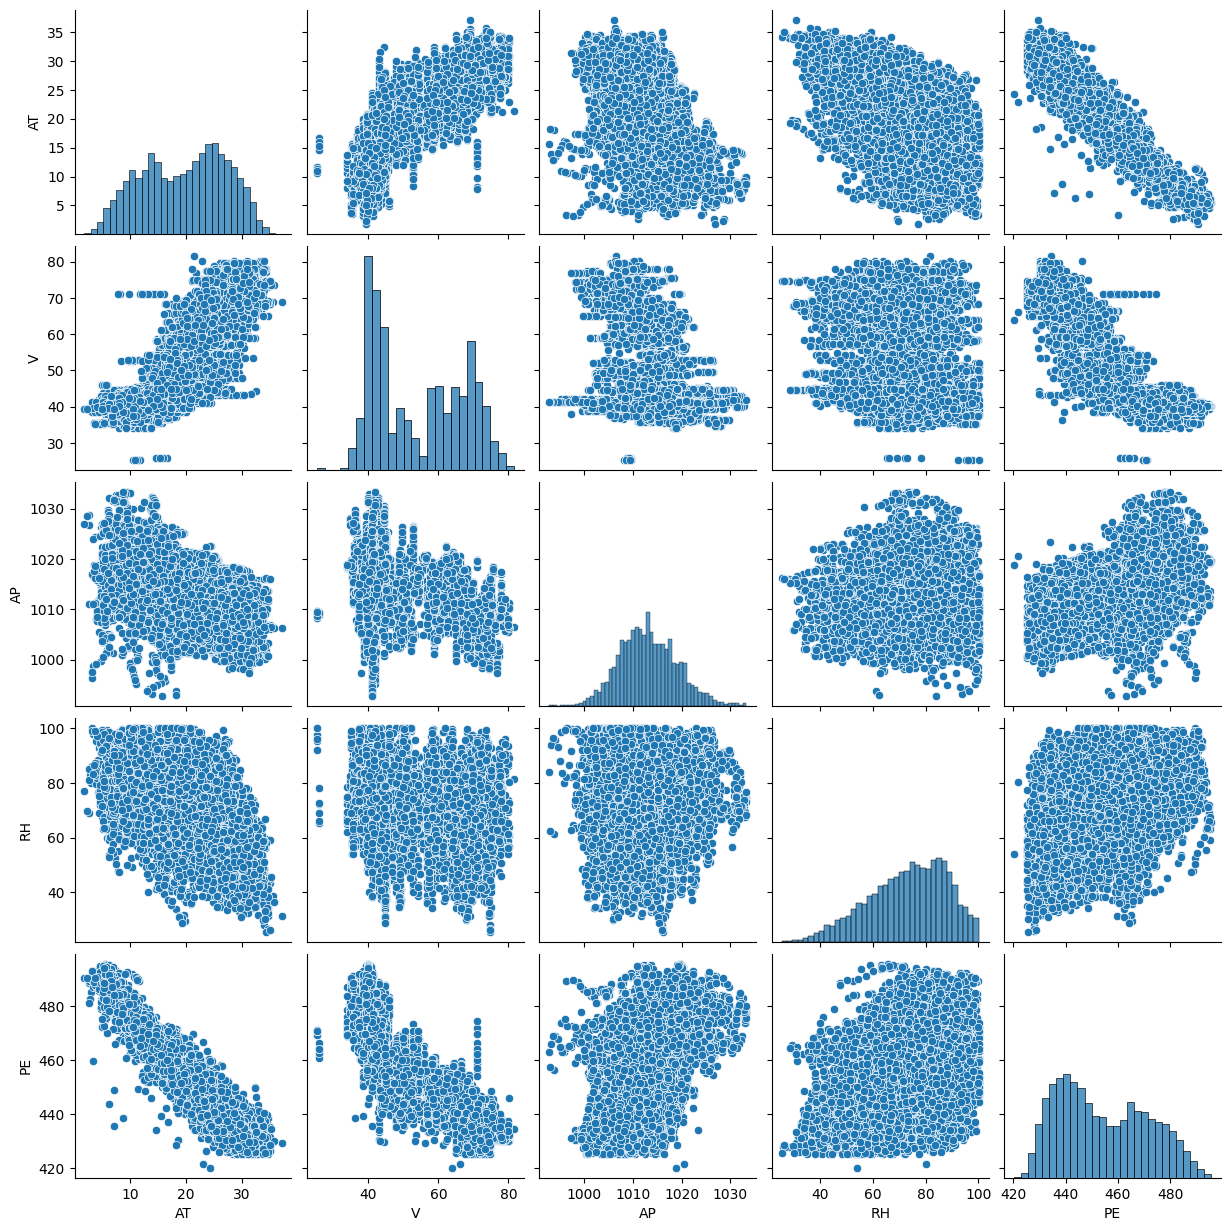

In [6]:
# make scatterplots of  all the varianbles in the dataset
fig = sns.pairplot(data = df)

Findings:
1. AT is positively correlated with V.
2. AT is negatively correlated with PE.
3. V is negatively correlated with PE.

#### iii. mean, the median, range, first and third quartiles, and interquartile ranges

In [7]:
means = []
medians = []
ranges = []
firstQuartiles = []
thirdQuartiles = []
interQuartiles = []

for c in df.columns:
    means.append(round(np.mean(df[c]), 2))
    medians.append(round(np.median(df[c]), 2))
    ranges.append(round(np.max(df[c]) - np.min(df[c]), 2))
    f = round(np.quantile(df[c], 0.25), 2)
    firstQuartiles.append(f)
    t = round(np.quantile(df[c], 0.75), 2)
    thirdQuartiles.append(t)
    interQuartiles.append(round(t - f, 2))

# refer to https://pypi.org/project/prettytable/
def generate_table(headers, rows):
    pt = PrettyTable()
    pt.field_names = headers
    for row in rows:
        pt.add_row(row)
    return pt

fheaders = ["Features","Mean","Median","Range","First Quartiles","Third QUartiles","interquartile Range"]
frows = []
for i in range(len(df.columns)):
    frows.append([df.columns[i], means[i], medians[i], ranges[i], firstQuartiles[i], thirdQuartiles[i], interQuartiles[i]])
print(generate_table(fheaders, frows))


    

+----------+---------+---------+-------+-----------------+-----------------+---------------------+
| Features |   Mean  |  Median | Range | First Quartiles | Third QUartiles | interquartile Range |
+----------+---------+---------+-------+-----------------+-----------------+---------------------+
|    AT    |  19.65  |  20.34  |  35.3 |      13.51      |      25.72      |        12.21        |
|    V     |  54.31  |  52.08  |  56.2 |      41.74      |      66.54      |         24.8        |
|    AP    | 1013.26 | 1012.94 | 40.41 |      1009.1     |     1017.26     |         8.16        |
|    RH    |  73.31  |  74.97  |  74.6 |      63.33      |      84.83      |         21.5        |
|    PE    |  454.37 |  451.55 |  75.5 |      439.75     |      468.43     |        28.68        |
+----------+---------+---------+-------+-----------------+-----------------+---------------------+


### (c) Simple Linear Regression

In [8]:
coefficients = {}
def predict_and_describe(feature):
    print(f"Summary of predictor_value = {feature}")
    if (feature != "PE"):
        y = df["PE"].to_numpy()
        x = df[feature].to_numpy()

        # fit a simple linear regression model to predict the response
        x_constant = sm.add_constant(x, prepend=False)
        model = sm.OLS(y, x_constant).fit()
        print(model.summary())

        # get indices of outliers
        influence = model.get_influence()
        cooks = influence.cooks_distance
        indices = np.where(cooks[0] > 4 / len(df))

        coefficients[feature] = model.params
        #  Create plots to show the  linear regression
        fig, axes = plt.subplots(figsize=(6, 4))    
        axes.set_title(f"Linear Regression of {feature}")
        axes.set_xlabel(feature)
        axes.set_ylabel("PE")

        with plt.style.context('ggplot'):
            axes.plot(x, model.predict(x_constant), "tab:red", label="Linear Regression")
            axes.scatter(x, y, alpha=0.3, label="Data point")
            axes.scatter(x[indices], y[indices], marker="+", label="Outliers")
            
        axes.legend()
        plt.show()

        outliers = np.vstack((x[indices], y[indices]))
        return pd.DataFrame(outliers)



#### There's a statistically significant association between the predictor and the response in the following model, because p-value < 0.05. Outliers that deviate too far from the regression line are the ones I would like to remove from my data. Such as a few outliers in the lower left area.

Summary of predictor_value = AT
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 8.510e+04
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        09:54:11   Log-Likelihood:                -29756.
No. Observations:                9568   AIC:                         5.952e+04
Df Residuals:                    9566   BIC:                         5.953e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -2.171

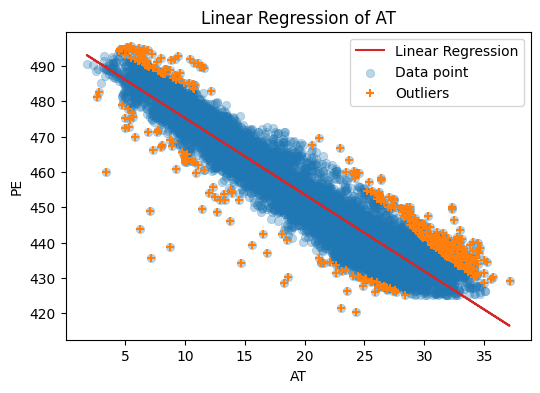

        AT      PE
0     5.41  495.24
1    29.01  446.22
2    32.72  437.99
3    35.56  429.69
4    27.54  450.22
..     ...     ...
411  33.20  438.12
412  30.26  442.98
413  34.03  440.29
414   5.01  475.34
415  26.22  454.20

[416 rows x 2 columns]


In [9]:
outlier_AT = predict_and_describe("AT")
curr = outlier_AT.T
curr.columns = ["AT", "PE"]

if outlier_AT.empty:
    print("There's no outliers.")
else:
    print(curr)

#### There's a statistically significant association between the predictor and the response in the following model, because p-value < 0.05. Outliers that deviate too far from the regression line are the ones I would like to remove from my data. Such as a few outliers at left and at right in a vertical direction.

Summary of predictor_value = V
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                 2.972e+04
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        09:54:12   Log-Likelihood:                -33963.
No. Observations:                9568   AIC:                         6.793e+04
Df Residuals:                    9566   BIC:                         6.794e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.1681

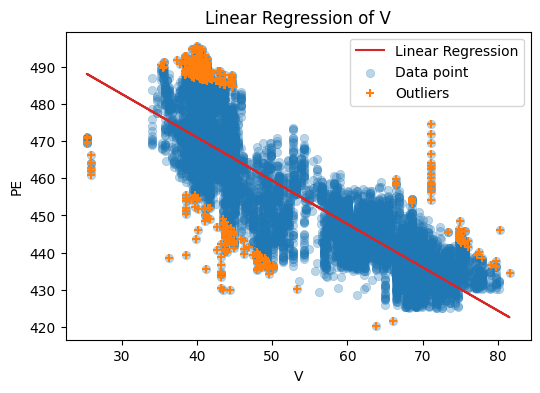

         V      PE
0    39.40  488.56
1    40.07  495.24
2    48.60  436.06
3    43.43  448.06
4    39.33  491.49
..     ...     ...
418  75.23  443.78
419  39.72  455.58
420  44.89  445.45
421  43.77  446.05
422  25.36  470.90

[423 rows x 2 columns]


In [10]:
outlier_V = predict_and_describe("V")
curr = outlier_V.T
curr.columns = ["V", "PE"]

if outlier_V.empty:
    print("There's no outliers.")
else:
    print(curr)

#### There's a statistically significant association between the predictor and the response in the following model, because p-value < 0.05. Outliers that deviate too far from the regression line are the ones I would like to remove from my data. Such as a few outliers in the upper left area.

Summary of predictor_value = AP
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     3516.
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        09:54:12   Log-Likelihood:                -39224.
No. Observations:                9568   AIC:                         7.845e+04
Df Residuals:                    9566   BIC:                         7.847e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.489

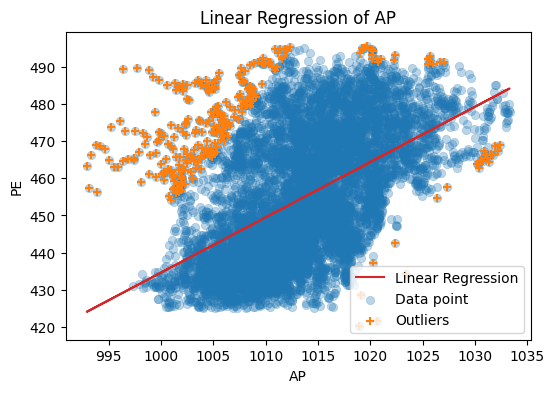

          AP      PE
0    1019.16  495.24
1    1008.52  483.80
2    1010.18  491.49
3    1008.82  481.09
4    1001.24  459.36
..       ...     ...
295  1030.61  464.95
296  1008.43  484.75
297  1005.24  479.22
298   998.27  472.16
299  1003.69  475.34

[300 rows x 2 columns]


In [11]:
outlier_AP = predict_and_describe("AP")
curr = outlier_AP.T
curr.columns = ["AP", "PE"]

if outlier_AP.empty:
    print("There's no outliers.")
else:
    print(curr)

#### There's a statistically significant association between the predictor and the response in the following model, because p-value < 0.05. Outliers that deviate too far from the regression line are the ones I would like to remove from my data. Such as a few outliers in the upper left area.

Summary of predictor_value = RH
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     1714.
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        09:54:13   Log-Likelihood:                -39933.
No. Observations:                9568   AIC:                         7.987e+04
Df Residuals:                    9566   BIC:                         7.988e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.455

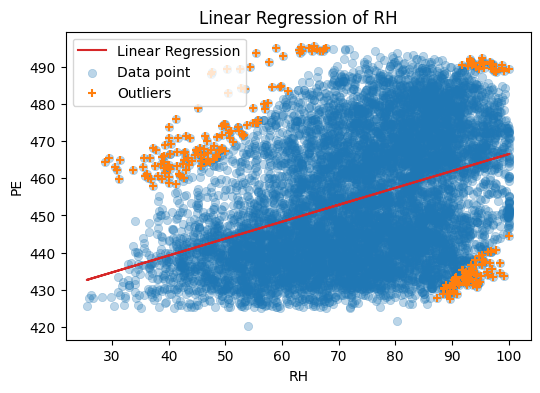

        RH      PE
0    41.25  475.98
1    43.08  462.19
2    48.84  467.54
3    64.77  495.24
4    50.00  474.60
..     ...     ...
244  97.21  490.68
245  98.84  490.50
246  90.20  430.55
247  93.39  434.11
248  99.27  433.62

[249 rows x 2 columns]


In [12]:
outlier_RH = predict_and_describe("RH")
curr = outlier_RH.T
curr.columns = ["RH", "PE"]

if outlier_RH.empty:
    print("There's no outliers.")
else:
    print(curr)

### (d) Multiple Regression

In [13]:
mtl_coefficients = []
# divided the trainset and testset
trainset = df.iloc[:,:-1]
testset = df.iloc[:,-1]

# fit a multiple regression model
multi_model = LinearRegression().fit(trainset, testset)
prediction = multi_model.predict(trainset)

trainset = sm.add_constant(trainset)
modelOLS = sm.OLS(testset, trainset)
response = modelOLS.fit()
prediction = response.predict(trainset)

for i in range(1, len(response.params)):
    mtl_coefficients.append(response.params[i])

print(response.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        09:54:14   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.6093      9.749     46.634      0.0

#### According to the results above, all the predictors' p-value is less than 0.05, so we can reject the null hypothesis H_0 : β_j = 0 for all the predictors.

### (e) 1c Compare to 1d

In [14]:
spl_coefficients = []
for co in coefficients:
    spl_coefficients.append(coefficients[co][0])
# print(spl_coefficients)


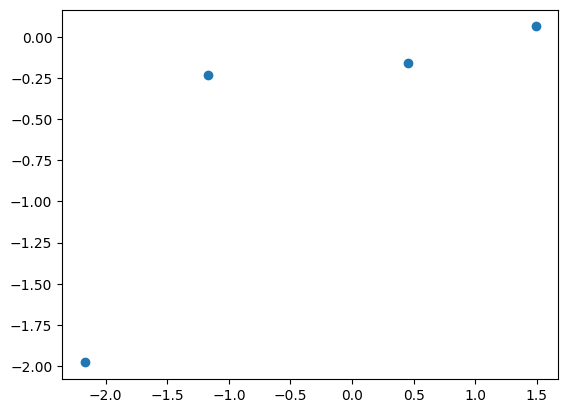

In [15]:
plt.scatter(spl_coefficients, mtl_coefficients)
plt.show()

### (f) Nonlinear Association

Summary of predictor_value = AT
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        09:54:14   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        492.728

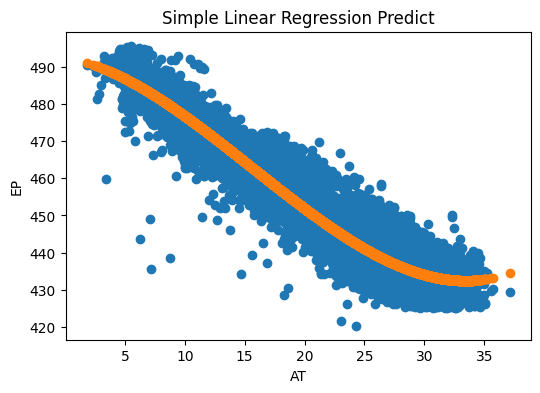

No handles with labels found to put in legend.


In [16]:
DEGREE = 3
EP = df.iloc[:,4]
def get_nonlinear_association(feature):
    poly = PolynomialFeatures(DEGREE)
    X = np.array(df[feature]).reshape((-1,1))
    polyData = poly.fit_transform(X)
    regression = LinearRegression().fit(polyData, EP)
    trainingX_poly = poly.fit_transform(df[feature].to_numpy().reshape(-1, 1))
    model = sm.OLS(df["PE"].to_numpy(), trainingX_poly).fit()
    
    print(f"Summary of predictor_value = {feature}")
    print(model.summary())

    
    fig, axes = plt.subplots(figsize=(6, 4))    
    axes.set_title(f"Nonlinear Association between {feature} and PE")
    axes.set_xlabel(feature)
    axes.set_ylabel("PE")

    plt.plot(df[feature], EP,'o')
    plt.title('Simple Linear Regression Predict')
    plt.xlabel(feature)
    plt.ylabel('EP')
    
    prediction = regression.predict(polyData)
    plt.plot(X, prediction, 'o')
    plt.show()
            
    axes.legend()
    plt.show()

get_nonlinear_association('AT')


Summary of predictor_value = V
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                 1.098e+04
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        09:54:15   Log-Likelihood:                -33585.
No. Observations:                9568   AIC:                         6.718e+04
Df Residuals:                    9564   BIC:                         6.721e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        554.1468

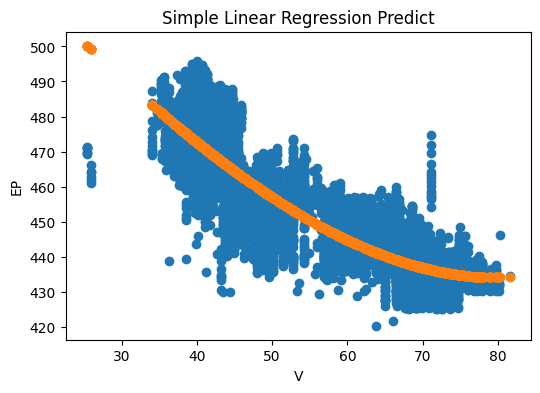

No handles with labels found to put in legend.


In [17]:
get_nonlinear_association('V')

Summary of predictor_value = AP
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     1813.
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        09:54:15   Log-Likelihood:                -39184.
No. Observations:                9568   AIC:                         7.837e+04
Df Residuals:                    9565   BIC:                         7.840e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.074

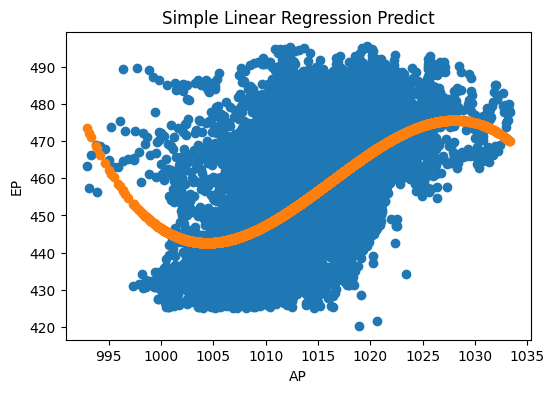

No handles with labels found to put in legend.


In [18]:
get_nonlinear_association('AP')

Summary of predictor_value = RH
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     579.2
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        09:54:15   Log-Likelihood:                -39923.
No. Observations:                9568   AIC:                         7.985e+04
Df Residuals:                    9564   BIC:                         7.988e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        468.413

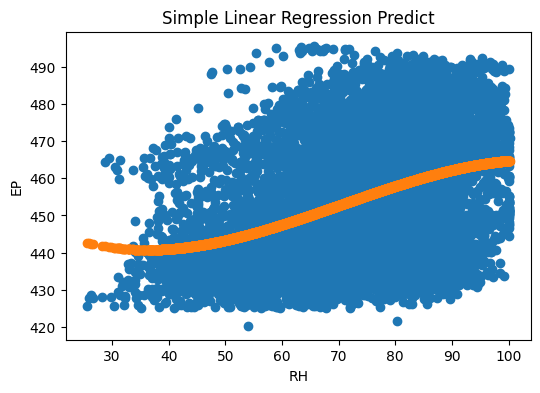

No handles with labels found to put in legend.


In [19]:
get_nonlinear_association('RH')

#### Conclusions
For features AT, AP and RH, the p-value is very small, which means we can reject the null hypothesis. Therefore, there is evidence of non-linear association between the predictor and the response.

However, for predictor V, the p-values for x^2 and x^3 are not negligible, which means we cannot reject the null hypothesis. Therefore, there is no non-linear association between the predictor and the response.

### (g) Interactions of Predictors

In [20]:
def predict_and_describe_polynomial(df, degree=2):
    # Separate features (X) and target (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Fit a polynomial regression model with pairwise interaction terms
    polyModel = PolynomialFeatures(degree, interaction_only=True) 
    polyFeature = polyModel.fit_transform(X)
    polyFeature = pd.DataFrame(polyFeature, columns=polyModel.get_feature_names())

    polyFeature = sm.add_constant(polyFeature)
    modelOLS = sm.OLS(y, polyFeature).fit()

    prediction = modelOLS.predict(polyFeature)

    print("\nNote: 'x0', 'x1', 'x2', 'x3' represent 'AT', 'V', 'AP', 'RH'.")
    print(modelOLS.summary())

    print("\nAll pairwise interaction terms ('x0', 'x1', 'x2', 'x3' represent 'AT', 'V', 'AP', 'RH'):")
    print(polyModel.get_feature_names())

predict_and_describe_polynomial(df, degree=2)


Note: 'x0', 'x1', 'x2', 'x3' represent 'AT', 'V', 'AP', 'RH'.
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        09:54:16   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

#### Conclusion
For those terms whose p-value < 0.05, the correspending interaction terms are statistically significant:

V, AP, RH, AT V, AT RH, V AP, AP RH

### (h) Improvement

In [30]:

# Train the regression model on a randomly selected 70% subset of the data with all predictors
indices = [i for i in range(9568)]
random.seed(9568)
random.shuffle(indices)

size = math.floor(len(df) * 0.7)
trainset = df.iloc[indices[:size], :]
testset = df.iloc[indices[size:], :]

df_x = df.iloc[:,:-1]
df_y = df.iloc[:, -1]
trainset_x, testset_x, trainset_y, testset_y = train_test_split(df_x, df_y, train_size=0.7, random_state=1)

# train the model
model1 = PolynomialFeatures(2, interaction_only=False) 
trainX = model1.fit_transform(trainset_x)
testX = model1.fit_transform(testset_x)
polyX = sm.add_constant(trainX)

# remove insignificant value
remove_trainX = trainX[:, [0,1,3,4,5,6,8,12,13,14]]
remove_testX = testX[:, [0,1,3,4,5,6,8,12,13,14]]

# train the model
model = sm.OLS(trainset_y, remove_trainX)
res = model.fit()
names = model1.get_feature_names()
names = np.delete(names, [2,7,9,10,11])

# predict and display
predict = res.predict(remove_testX)
mse1 = mean_squared_error(testset_y, predict)
print(res.summary())

print("MSE: ")
print(mse1)







                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.079e+04
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        10:13:18   Log-Likelihood:                -19302.
No. Observations:                6697   AIC:                         3.862e+04
Df Residuals:                    6687   BIC:                         3.869e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9585.3092   1094.750     -8.756      0.0

In [33]:
#  run a regression model involving all possible interaction terms and quadratic nonlinearities
trainset = df.iloc[:, :-1]
testset = df.iloc[:, -1]

# conduct linear regression and pridict the response
model2 = LinearRegression().fit(trainset, testset)
pred = model2.predict(trainset)
trainset = sm.add_constant(trainset)

# train the model
modelOLS = sm.OLS(testset, trainset)
res = modelOLS.fit()

# predict and display
pred = res.predict(trainset)
mse2 = mean_squared_error(testset, prediction)
print(res.summary())
print("MSE:")
print(mse2)

# update coefficients
coefficients = []
for i in range(1, len(res.params)):
    coefficients.append(res.params[i])



                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Thu, 21 Sep 2023   Prob (F-statistic):               0.00
Time:                        10:16:59   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.6093      9.749     46.634      0.0

### (i) KNN

In [46]:
summaries = {}
train_errors = []
test_errors = []
min_error1 = float("inf")
idx = 0
best_val = 5
k_rev = []

for k in range(1, 101):
    knnTest = KNeighborsRegressor(n_neighbors=k)
    knnTest.fit(trainset_x, trainset_y)

    # update error lists
    k_rev.append(1 / k)
    train_pred = knnTest.predict(trainset_x)
    test_pred = knnTest.predict(testset_x)
    train_mse = mean_squared_error(trainset_y, train_pred)
    test_mse = mean_squared_error(testset_y, test_pred)
    train_errors.append(train_mse)
    test_errors.append(test_mse)

    if test_mse < min_error1:
        min_error1 = test_mse
        idx = k - 1

mode = "RAW"
summaries[mode] = [train_errors[idx], test_errors[idx]]

headers = ["Mode","k","Train Error","Test Error"]
row = [["RAW",  round((1 / k_rev[idx]), 4), round(train_errors[idx], 4), round(test_errors[idx], 4)]]

print(generate_table(headers, row))

    
    
    


+------+-----+-------------+------------+
| Mode |  k  | Train Error | Test Error |
+------+-----+-------------+------------+
| RAW  | 5.0 |    10.553   |  15.7048   |
+------+-----+-------------+------------+


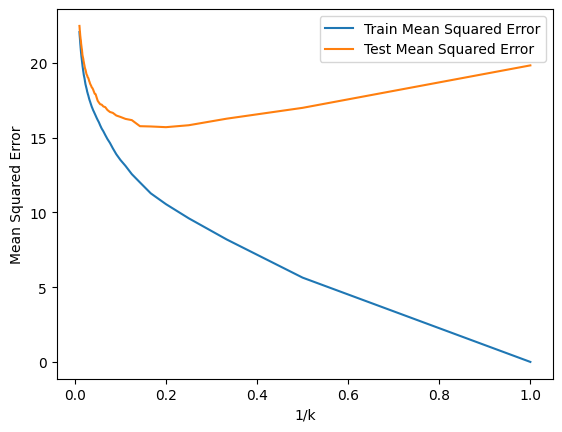

In [47]:
plt.plot(k_rev, train_errors, label="Train Mean Squared Error")
plt.plot(k_rev, test_errors, label="Test Mean Squared Error")
plt.gca().set_xlabel("1/k")
plt.gca().set_ylabel("Mean Squared Error")
plt.gca().legend()
plt.show()

In [48]:
train_errors = []
test_errors = []
min_error2 = float("inf")
idx = 0
best_val = 5
k_rev = []

scaler = MinMaxScaler()
train_x_nknn = scaler.fit_transform(trainset_x)
test_x_nknn = scaler.fit_transform(testset_x)

for k in range(1, 101):
    knnTest = KNeighborsRegressor(n_neighbors=k)
    knnTest.fit(train_x_nknn, trainset_y)

    # update error lists
    k_rev.append(1 / k)
    train_pred = knnTest.predict(train_x_nknn)
    test_pred = knnTest.predict(test_x_nknn)
    train_mse = mean_squared_error(trainset_y, train_pred)
    test_mse = mean_squared_error(testset_y, test_pred)
    train_errors.append(train_mse)
    test_errors.append(test_mse)

    if test_mse < min_error2:
        min_error2 = test_mse
        idx = k - 1

mode = "NORMALIZED"
summaries[mode] = [train_errors[idx], test_errors[idx]]
    
summary = {
    "mode": "NORMALIZED",
    "train_error": round(train_errors[idx], 4),
    "test_error": round(test_errors[idx], 4),
    "k_rev": k_rev,
    "k": round((1 / k_rev[idx]), 4)
}

headers = ["Mode","k","Train Error","Test Error"]
row = [[summary["mode"], summary["k"], summary["train_error"], summary["test_error"]]]

print(generate_table(headers, row))



+------------+-----+-------------+------------+
|    Mode    |  k  | Train Error | Test Error |
+------------+-----+-------------+------------+
| NORMALIZED | 7.0 |   11.0119   |  14.9106   |
+------------+-----+-------------+------------+


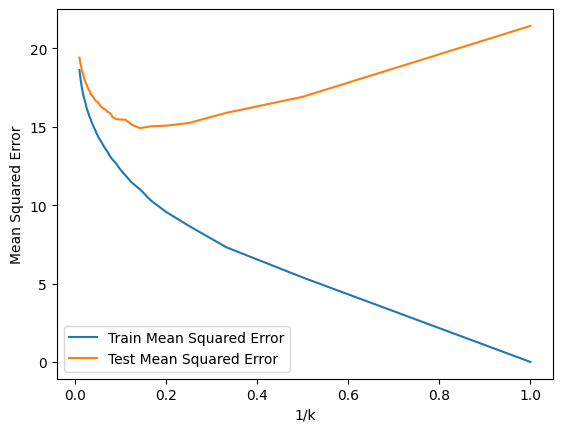

In [49]:
plt.plot(k_rev, train_errors, label="Train Mean Squared Error")
plt.plot(k_rev, test_errors, label="Test Mean Squared Error")
plt.gca().set_xlabel("1/k")
plt.gca().set_ylabel("Mean Squared Error")
plt.gca().legend()
plt.show()

### (j ) Compare KNN and Linear

In [50]:
headers = ["Polynomial Regreesion After Removing","Multi Linear Regression","Raw kNN Regression","Normalized kNN Regression"]
row = [[mse1, mse2, min_error1, min_error2]]

print(generate_table(headers, row))

+--------------------------------------+-------------------------+--------------------+---------------------------+
| Polynomial Regreesion After Removing | Multi Linear Regression | Raw kNN Regression | Normalized kNN Regression |
+--------------------------------------+-------------------------+--------------------+---------------------------+
|          18.71852376496725           |    20.767397532535004   | 15.704821203761764 |     14.910644795598495    |
+--------------------------------------+-------------------------+--------------------+---------------------------+


#### Conclusion
The error of normalized kNN model is the smallest, so it is better than Linear Regression. Probably because the data is non-linear, and the k we chose for knn is the best k value.

#### References:
https://pypi.org/project/prettytable/
https://www.statsmodels.org/dev/regression.html
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html